In [3]:
using PythonPlot
include("MDPModelFunctions2.jl")


    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonCall/wXfah/CondaPkg.toml
    CondaPkg Found dependencies: /Users/erussek/.julia/packages/PythonPlot/KcWMF/CondaPkg.toml
    CondaPkg Dependencies already up to date


sim_cowan_att (generic function with 1 method)

In [153]:
### goal is to sim for many different object loads 
N_Object_Vals = [2, 4, 6, 8]; # up to 10 objects to remember...

# For trials with a retro-cue

# Other values are time before cue and time after cue
N_Seconds_Pre_Vals = .5 * 2 .^ (0:5)
N_Seconds_Post_Vals = .5 * 2 .^ (0:5)

# For trials with no retro-cue - start from .25 seconds and multiply by 1.5 8 times
N_Seconds_NoCue = .5 * 2 .^ (0:7)

N_N_Object_vals = length(N_Object_Vals)
N_N_Seconds_Pre_Vals = length(N_Seconds_Pre_Vals)
N_N_Seconds_Post_Vals = length(N_Seconds_Post_Vals)
N_N_Seconds_NoCue = length(N_Seconds_NoCue)

#
mem_slopes = [.025, .05, .1, .2, .4, .8, 1.6]
N_mem_slopes = length(mem_slopes)

# N_Seconds_NoCue = [.25, .5, 1, 2, 4, 8]

7

In [154]:
# Run all delayed memory ones here.
N_Quanta = 20
epsilon = .75
NT_per_Sec = 50

# increase mem_slope so that it doubles each time
mem_slopes = [.025, .05, .1, .2, .4, .8, 1.6]

N_Trials = 1000 # potentially could be 500

# N_Obj_idx = 5
# loop through all object values

delay_prob_correct = zeros(N_N_Object_vals, N_N_Seconds_NoCue, length(mem_slopes))

for N_Obj_idx = 1:N_N_Object_vals

    # First we'll simulate the model without a retro-cue

    N_Objects = N_Object_Vals[N_Obj_idx]
    print(N_Objects)
    N_Seconds = N_Seconds_NoCue[end]

    N_TimeSteps_Pre = Int(round(N_Seconds * NT_per_Sec))
    N_TimeSteps_Post = 0


    # prob correct is Num Time Steps X Num Objects X Num Mem Slopes
    prob_correct = simulate_task_mult_ms(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, N_Trials, simulate_delayed_memory_episode; mem_slopes = mem_slopes, cue_reliability = 1, baseline_prob = .5)

    # grab the time-points from prob_correct that are relevant
    Relevant_Timepoint = Int.(round.(N_Seconds_NoCue.*NT_per_Sec))
    delay_prob_correct[N_Obj_idx, : , :] = prob_correct[Relevant_Timepoint, 1, :];
end


2468

In [155]:


N_Seconds_Post = N_Seconds_Post_Vals[end]

N_TimeSteps_Post = Int(ceil(N_Seconds_Post * NT_per_Sec))

# need to repeat this for every pre-timepoint and store results in a 3D array - Dimensions: Num Pre-Timepoints X Num Post-Timepoints X Num Mem Slopes
retro_cue_prob_correct = zeros(N_N_Object_vals, N_N_Seconds_Pre_Vals, N_N_Seconds_Post_Vals, N_mem_slopes)

for N_Obj_idx = 1:N_N_Object_vals
    
    N_Objects = N_Object_Vals[N_Obj_idx]
    print(N_Objects)
    
    # loop through all pre-timepoints
    for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
        N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]
        N_TimeSteps_Pre = Int(round(N_Seconds_Pre * NT_per_Sec))
        
        prob_correct = simulate_task_mult_ms(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, N_Trials, simulate_retrocue_episode; mem_slopes = mem_slopes, cue_reliability = 1, baseline_prob = .5)
            
        Relevant_Timepoint = Int.(round.((N_Seconds_Pre .+  N_Seconds_Post_Vals).*NT_per_Sec))
        retro_cue_prob_correct[N_Obj_idx, N_Sec_Pre_idx, :, :] = prob_correct[Relevant_Timepoint, 1, :]; # also only care about the first item

    end
end

2468

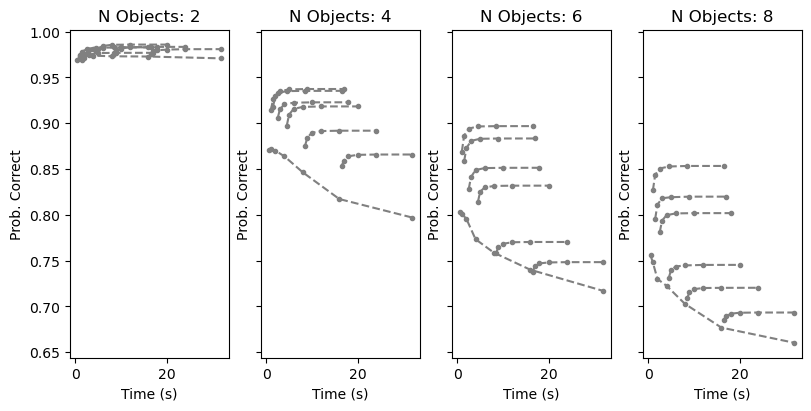

In [166]:
# plot prob correct at relevant time points as a function of N_Seconds_NoCue for each mem slope
# set axis to be constrained layout

fig, ax = subplots(1, N_N_object_vals, figsize=(8, 4), dpi=100, constrained_layout=true, sharex = true, sharey = true)

ms_idx = 5


# loop through N_Object_vals
for N_Obj_idx = 1:N_N_Object_vals
    ax[N_Obj_idx-1].plot(N_Seconds_NoCue[1:end-1], delay_prob_correct[N_Obj_idx, 1:end-1, ms_idx], "--o", color = "gray", ms = 3)
    ax[N_Obj_idx-1].set_title("N Objects: $(N_Object_Vals[N_Obj_idx])")
    ax[N_Obj_idx-1].set_xlabel("Time (s)")
    ax[N_Obj_idx-1].set_ylabel("Prob. Correct")
end

# set color of each line to be gray-scale with intensity based on N_Sec_Pre_idx
# Normalize N_Seconds_Pre_Vals to [0, 1]
min_val = minimum(N_Seconds_Pre_Vals)
max_val = maximum(N_Seconds_Pre_Vals)
normalized_idx = (N_Seconds_Pre_Vals .- min_val) ./ (max_val - min_val)


for N_Obj_idx = 1:N_N_Object_vals
    for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
        N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]
        ax[N_Obj_idx-1].plot(N_Seconds_Pre .+ N_Seconds_Post_Vals, retro_cue_prob_correct[N_Obj_idx, N_Sec_Pre_idx, :, ms_idx], "--o", ms = 3, color = "gray", label = "$(round(N_Seconds_Pre, digits = 2))")
    end
end

